In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import torch
import random

from sae.sparse_autoencoder import load_saved_sae
from sae.metrics import model_store_from_sae
from unlearning.metrics import convert_wmdp_data_to_prompt
from unlearning.tool import UnlearningConfig, SAEUnlearningTool, MCQ_ActivationStoreAnalysis

from huggingface_hub import hf_hub_download
from datasets import load_dataset
import numpy as np
import pandas as pd
import itertools
from transformer_lens import utils

from jaxtyping import Float
from torch import Tensor

from pathlib import Path

import plotly.express as px


In [11]:
# resid pre 9
REPO_ID = "eoinf/unlearning_saes"
FILENAME = "jolly-dream-40/sparse_autoencoder_gemma-2b-it_blocks.9.hook_resid_pre_s16384_127995904.pt"

filename = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
sae = load_saved_sae(filename)

model = model_store_from_sae(sae)

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model gemma-2b-it into HookedTransformer
Moving model to device:  cuda


In [12]:
filename = "../data/wmdp-bio_gemma_2b_it_correct.csv"
correct_question_ids = np.genfromtxt(filename)

dataset_args = {
    'question_subset': correct_question_ids,
}

sae.cfg.n_batches_in_store_buffer = 86

act_store = MCQ_ActivationStoreAnalysis(sae.cfg, model, dataset_args=dataset_args)
unlearning_metric = 'wmdp-bio_gemma_2b_it_correct'

unlearn_cfg = UnlearningConfig(unlearn_activation_store=act_store, unlearning_metric=unlearning_metric)
ul_tool2 = SAEUnlearningTool(unlearn_cfg)
ul_tool2.setup(model=model)
ul_tool2.get_metrics_with_text()

Generating test split:   0%|          | 0/1273 [00:00<?, ? examples/s]

dataloader


buffer
dataloader


100%|██████████| 43/43 [00:23<00:00,  1.82it/s]


tokens torch.Size([172, 1024]) 1024
tokens torch.Size([172, 1024])
Concatenating learned activations
Done


100%|██████████| 43/43 [00:03<00:00, 11.04it/s]


tokens torch.Size([172, 1024]) 1024
tokens torch.Size([172, 1024])
Concatenating learned activations
Done


In [13]:
# setup unlearning tool, need about 3 minutes to run this cell

filename = "../data/wmdp-bio_gemma_2b_it_correct.csv"
correct_question_ids = np.genfromtxt(filename)

dataset_args = {
    'question_subset': correct_question_ids,
}

sae.cfg.n_batches_in_store_buffer = 86
# unlearn_activation_store = MCQ_ActivationStoreAnalysis(sae.cfg, model, dataset_args=dataset_args)
unlearning_metric = 'wmdp-bio_gemma_2b_it_correct'


unlearn_cfg = UnlearningConfig(unlearn_activation_store=None, unlearning_metric=unlearning_metric)
ul_tool = SAEUnlearningTool(unlearn_cfg)
ul_tool.setup(create_base_act_store=False, create_unlearn_act_store=False, model=model)
# ul_tool.get_metrics_with_text()

In [14]:
# read 172 questions that the model can answer correctly in any permutation
filename = '../data/wmdp-bio_gemma_2b_it_correct.csv'
correct_question_ids = np.genfromtxt(filename)


# read 133 questions that the model can answer correctly in any permutation but will get it wrong if
# without the instruction prompt and the question prompt
filename = '../data/wmdp-bio_gemma_2b_it_correct_not_correct_wo_question_prompt.csv'
correct_question_id_not_correct_wo_question_prompt = np.genfromtxt(filename).astype(int)


In [15]:
# question_ids = np.genfromtxt(filename).astype(int)
len(correct_question_ids)

172

In [16]:
# pass in the dataset as an argument so no need to load in everytime
dataset = load_dataset("cais/wmdp", "wmdp-bio")

answers = [x['answer'] for x in dataset['test']]
questions = [x['question'] for x in dataset['test']]
choices_list = [x['choices'] for x in dataset['test']]

prompts = [convert_wmdp_data_to_prompt(question, choices, prompt_format=None) for question, choices in zip(questions, choices_list)]


In [17]:
# load good feature list
import pickle
with open('../yeutong_notebooks/unlearning_output/good_features_list_v1.pkl', 'rb') as f:
    good_features_list = pickle.load(f)

good_features_list

{70: [4802],
 89: [2993],
 158: [11019, 4802],
 172: [2993, 12273, 4802],
 190: [2993, 6958],
 192: [4342, 6325, 2993],
 200: [9280],
 203: [2993, 4802, 1307],
 216: [3652, 4802],
 217: [1523, 2993],
 218: [],
 243: [2993, 4802],
 265: [2993],
 267: [4802],
 314: [4802, 6273],
 324: [7983],
 345: [2993, 4802, 15848],
 348: [14315],
 353: [2993, 4802, 6958, 3652],
 354: [2993, 4802],
 357: [4802, 2993],
 359: [4802],
 360: [4802, 2993],
 362: [2993, 4802],
 367: [],
 373: [2993, 12663, 4802],
 375: [2993, 6531, 4802],
 376: [4802],
 377: [4802],
 378: [4291],
 384: [2993],
 405: [4291, 4802, 5691],
 447: [3652],
 452: [4802, 2993],
 474: [15858],
 479: [2993],
 482: [],
 494: [10355, 2993, 9391],
 513: [1746, 4802],
 534: [6273, 4802],
 542: [2993, 12289, 12663],
 584: [2993],
 600: [15858, 12289],
 612: [2993, 4802],
 617: [2993, 4802],
 626: [2993],
 630: [3652],
 636: [2993],
 645: [2993, 1611, 10051, 12289],
 649: [2993, 4802],
 650: [5749, 16186, 4802, 4451, 5861],
 652: [2993, 143

In [4]:
features_to_test = list(set([item for sublist in good_features_list.values() for item in sublist]))


In [5]:
len(features_to_test)

41

In [6]:
loss_intervention_results2 = []
metrics_intervention_results2 = []

In [7]:
filtered_good_features = [12663, 4342, 5749, 10355, 1523, 15858, 12273, 14315, 4451, 1611, 10051, 16186, 7983, 6958, 1307, 11019, 6531, 12289]

a = [x for x in filtered_good_features if x in features_to_test]
len(a)

18

In [18]:
loss_intervention_results = []
metrics_intervention_results = []

filtered_good_features = [12663, 4342, 5749, 10355, 1523, 15858, 12273, 14315, 4451, 1611, 10051, 16186, 7983, 6958, 1307, 11019, 6531, 12289]
# filtered_good_features = [12663, 4342, 5749, 10355, 1523, 15858, 12273, 14315, 4451, 1611, 10051, 16186, 7983, 6958, 1307, 11019, 6531, 12289]

all_permutations = list(itertools.permutations([0, 1, 2, 3]))


for feature in filtered_good_features:
    ul_tool2.base_activation_store.iterable_dataset = iter(ul_tool2.base_activation_store.dataset)
    ablate_params = {
        'features_to_ablate': [feature],
        'multiplier': 20,
        'intervention_method': 'scale_feature_activation',
        'permutations': None,
    }
    
    metrics = ul_tool2.calculate_metrics(**ablate_params)
    metrics_intervention_results.append(metrics)
    loss_added = ul_tool2.compute_loss_added(n_batch=20, **ablate_params)
    loss_intervention_results.append(loss_added)


  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


In [19]:
# Calculate max activations
mean_activations = ul_tool2.unlearn_metrics_with_text['learned_activations'].mean(dim=0)
max_activations = ul_tool2.unlearn_metrics_with_text['learned_activations'].max(dim=0)[0]

In [31]:
loss_intervention_results

[0.002839469909667969,
 -6.710290908813476e-05,
 0.009702324867248535,
 0.005494749546051026,
 0.004311501979827881,
 -4.76837158203125e-07,
 -0.00011782646179199218,
 -0.00010492801666259766,
 0.02195502519607544,
 0.002906322479248047,
 -3.6597251892089844e-05,
 -0.000269472599029541,
 -0.00027120113372802734,
 1.938343048095703e-05,
 0.011131656169891358,
 0.033754920959472655,
 0.003141331672668457,
 0.02086029052734375]

In [35]:
i_sorted_by_loss = np.argsort(loss_intervention_results)
filtered_good_features_sorted_by_loss = np.array(filtered_good_features)[i_sorted_by_loss]
filtered_good_features_sorted_by_loss

array([ 7983, 16186, 12273, 14315,  4342, 10051, 15858,  6958, 12663,
        1611,  6531,  1523, 10355,  5749,  1307, 12289,  4451, 11019])

In [36]:
np.array(loss_intervention_results)[i_sorted_by_loss]

array([-2.71201134e-04, -2.69472599e-04, -1.17826462e-04, -1.04928017e-04,
       -6.71029091e-05, -3.65972519e-05, -4.76837158e-07,  1.93834305e-05,
        2.83946991e-03,  2.90632248e-03,  3.14133167e-03,  4.31150198e-03,
        5.49474955e-03,  9.70232487e-03,  1.11316562e-02,  2.08602905e-02,
        2.19550252e-02,  3.37549210e-02])

In [39]:
# Do cumulative pass over features

# control_metrics_results2 = []
loss_intervention_results2 = []
metrics_intervention_results2 = []

# filtered_good_features = [12663, 4342, 5749, 10355, 1523, 15858, 12273, 14315, 4451, 1611, 10051, 16186, 7983, 6958, 1307, 11019, 6531, 12289]
# filtered_good_features = [12663, 4342, 5749, 10355, 1523, 15858, 12273, 14315, 4451, 1611, 10051, 16186, 7983, 6958, 1307, 11019, 6531, 12289]
# good_features_sorted_by_loss = np.array(filtered_good_features)[i_sorted_by_loss]

all_permutations = list(itertools.permutations([0, 1, 2, 3]))


for i in range(4):
    ul_tool2.base_activation_store.iterable_dataset = iter(ul_tool2.base_activation_store.dataset)
    ablate_params = {
        'features_to_ablate': filtered_good_features_sorted_by_loss[:i+1],
        'multiplier': 20,
        'intervention_method': 'scale_feature_activation',
        'permutations': None,
    }
    
    metrics = ul_tool2.calculate_metrics(**ablate_params)
    metrics_intervention_results2.append(metrics)
    loss_added = ul_tool2.compute_loss_added(n_batch=10, **ablate_params)
    loss_intervention_results2.append(loss_added)
    
    # control_metrics = ul_tool.calculate_control_metrics(random_select_one=False, **ablate_params)
    # control_metrics_results2.append(control_metrics)


  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


In [40]:
loss_intervention_results2
unlearned_frac = [x['modified_metrics']['mean_correct'] for x in metrics_intervention_results2]

list(zip(loss_intervention_results2, unlearned_frac))

[(-0.0005425691604614257, 0.9883720874786377),
 (-0.0012538909912109375, 0.9825581312179565),
 (-0.0012538909912109375, 0.8604651093482971),
 (-0.0016951799392700196, 0.8488371968269348)]

In [41]:
loss_intervention_results2
unlearned_frac = [x['modified_metrics']['mean_correct'] for x in metrics_intervention_results2]

list(zip(loss_intervention_results2, unlearned_frac))

[(-0.0005425691604614257, 0.9883720874786377),
 (-0.0012538909912109375, 0.9825581312179565),
 (-0.0012538909912109375, 0.8604651093482971),
 (-0.0016951799392700196, 0.8488371968269348)]

In [88]:
temp = [x['mean_correct'] for x in control_metrics_results2]
temp


[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9333333969116211,
 0.9333333969116211,
 0.9333333969116211,
 0.9000000357627869,
 0.9333333969116211,
 0.9333333969116211,
 0.9000000357627869,
 0.9000000357627869,
 0.8666667342185974,
 0.8666667342185974]

In [ ]:
# Do cumulative pass over features

# control_metrics_results2 = []
loss_intervention_results4 = []
metrics_intervention_results4 = []

filtered_good_features = [12663, 4342, 5749, 10355, 1523, 15858, 12273, 14315, 4451, 1611, 10051, 16186, 7983, 6958, 1307, 11019, 6531, 12289]
# filtered_good_features = [12663, 4342, 5749, 10355, 1523, 15858, 12273, 14315, 4451, 1611, 10051, 16186, 7983, 6958, 1307, 11019, 6531, 12289]
# good_features_sorted_by_loss = np.array(filtered_good_features)[i_sorted_by_loss]

features_to_test_sorted_by_loss = np.array(features_to_test)[i_sorted_by_loss]

all_permutations = list(itertools.permutations([0, 1, 2, 3]))


for i in range(len(2)):
    ul_tool2.base_activation_store.iterable_dataset = iter(ul_tool2.base_activation_store.dataset)
    ablate_params = {
        'features_to_ablate': features_to_test_sorted_by_loss[:i+1],
        'multiplier': 20,
        'intervention_method': 'scale_feature_activation',
        'permutations': None,
    }
    
    metrics = ul_tool2.calculate_metrics(**ablate_params)
    metrics_intervention_results4.append(metrics)
    loss_added = ul_tool2.compute_loss_added(n_batch=10, **ablate_params)
    loss_intervention_results4.append(loss_added)
    
    # control_metrics = ul_tool.calculate_control_metrics(random_select_one=False, **ablate_params)
    # control_metrics_results2.append(control_metrics)


In [ ]:
# Do cumulative pass over features

# control_metrics_results2 = []
loss_intervention_results2 = []
metrics_intervention_results2 = []

filtered_good_features = [12663, 4342, 5749, 10355, 1523, 15858, 12273, 14315, 4451, 1611, 10051, 16186, 7983, 6958, 1307, 11019, 6531, 12289]
# filtered_good_features = [12663, 4342, 5749, 10355, 1523, 15858, 12273, 14315, 4451, 1611, 10051, 16186, 7983, 6958, 1307, 11019, 6531, 12289]
# good_features_sorted_by_loss = np.array(filtered_good_features)[i_sorted_by_loss]

features_to_test_sorted_by_loss = np.array(features_to_test)[i_sorted_by_loss]

all_permutations = list(itertools.permutations([0, 1, 2, 3]))


for i in range(len(features_to_test_sorted_by_loss)):
    ul_tool2.base_activation_store.iterable_dataset = iter(ul_tool2.base_activation_store.dataset)
    ablate_params = {
        'features_to_ablate': features_to_test_sorted_by_loss[:i+1],
        'multiplier': 20,
        'intervention_method': 'scale_feature_activation',
        'permutations': None,
    }
    
    metrics = ul_tool2.calculate_metrics(**ablate_params)
    metrics_intervention_results2.append(metrics)
    loss_added = ul_tool2.compute_loss_added(n_batch=10, **ablate_params)
    loss_intervention_results2.append(loss_added)
    
    # control_metrics = ul_tool.calculate_control_metrics(random_select_one=False, **ablate_params)
    # control_metrics_results2.append(control_metrics)


In [ ]:
# loss_intervention_results3 = []
# metrics_intervention_results3 = []

In [84]:
control_metrics_results3 = []

In [85]:
filtered_good_features = [12663, 4342, 5749, 10355, 1523, 15858, 12273, 14315, 4451, 1611, 10051, 16186, 7983, 6958, 1307, 11019, 6531, 12289]
# filtered_good_features = [12663, 4342, 5749, 10355, 1523, 15858, 12273, 14315, 4451, 1611, 10051, 16186, 7983, 6958, 1307, 11019, 6531, 12289]

all_permutations = list(itertools.permutations([0, 1, 2, 3]))


for feature in good_features_sorted_by_loss[:10]:
    ul_tool2.base_activation_store.iterable_dataset = iter(ul_tool2.base_activation_store.dataset)
    ablate_params = {
        'features_to_ablate': [feature],
        'multiplier': 30.0,
        'intervention_method': 'clamp_feature_activation', #'scale_feature_activation',
        'permutations': None,
    }
    
    # metrics = ul_tool2.calculate_metrics(**ablate_params)
    # metrics_intervention_results3.append(metrics)
    # loss_added = ul_tool2.compute_loss_added(n_batch=20, **ablate_params)
    # loss_intervention_results3.append(loss_added)
    control_metrics = ul_tool.calculate_control_metrics(random_select_one=False, **ablate_params)
    control_metrics_results3.append(control_metrics)


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


In [86]:
temp = [x['mean_correct'] for x in control_metrics_results3]
temp


[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9000000357627869,
 0.8666667342185974]

In [77]:

unlearned_frac3 = [x['modified_metrics']['mean_correct'] for x in metrics_intervention_results3]

list(zip(loss_intervention_results3, unlearned_frac3))
# unlearned_frac3

[(-0.0009666204452514649, 0.9825581312179565),
 (-0.00020639896392822267, 0.9941860437393188),
 (-0.00020133256912231446, 0.7965116500854492),
 (-3.372430801391601e-05, 0.9883720874786377),
 (-0.0006420373916625977, 0.9941860437393188),
 (0.0003710150718688965, 0.9593023061752319),
 (-2.4116039276123048e-05, 0.7267441749572754),
 (0.00010329484939575195, 0.854651153087616),
 (-0.0015086770057678224, 0.6220930218696594),
 (0.002650284767150879, 0.8662790656089783)]

In [78]:
unlearned_frac3 = [x['modified_metrics']['mean_predicted_prob_of_correct_answers'] for x in metrics_intervention_results3]


In [81]:
metrics_intervention_results3[-2]['modified_metrics']['mean_predicted_prob_of_correct_answers']

0.6058086156845093

In [80]:
metrics_intervention_results3[0]['baseline_metrics']['mean_predicted_prob_of_correct_answers']

0.9954435229301453

In [65]:
# metrics_intervention_results2[0]['modified_metrics']
[x['modified_metrics']['mean_correct'] for x in metrics_intervention_results2]

[1.0,
 0.9825581312179565,
 0.9476743936538696,
 0.8430232405662537,
 0.680232584476471,
 0.5581395626068115,
 0.41860464215278625,
 0.35465115308761597,
 0.31976744532585144,
 0.2616279125213623,
 0.22674418985843658]

In [66]:
[x for x in loss_intervention_results2]

[0.0,
 -4.4178962707519534e-05,
 -0.00017495155334472655,
 -0.001829838752746582,
 0.0012744903564453126,
 0.006757378578186035,
 0.014585351943969727,
 0.023165035247802734,
 0.03226187229156494,
 0.042382335662841795,
 0.05386528968811035]

In [73]:
import matplotlib as mpl
from cycler import cycler

mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 1.4

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.major.width'] = 0.4
mpl.rcParams['xtick.minor.width'] = 0.4
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.major.width'] = 0.4
mpl.rcParams['ytick.minor.width'] = 0.4
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 10


mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 9

mpl.rcParams['figure.figsize'] = 6, 4

mpl.rcParams['axes.prop_cycle'] = cycler("color", ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])


# Plotting
figdir = "../figs"

In [70]:
unlearned_frac

[1.0,
 0.9825581312179565,
 0.9476743936538696,
 0.8430232405662537,
 0.680232584476471,
 0.5581395626068115,
 0.41860464215278625,
 0.35465115308761597,
 0.31976744532585144,
 0.2616279125213623,
 0.22674418985843658,
 0.21511627733707428,
 0.21511627733707428,
 0.20348836481571198,
 0.20930232107639313]

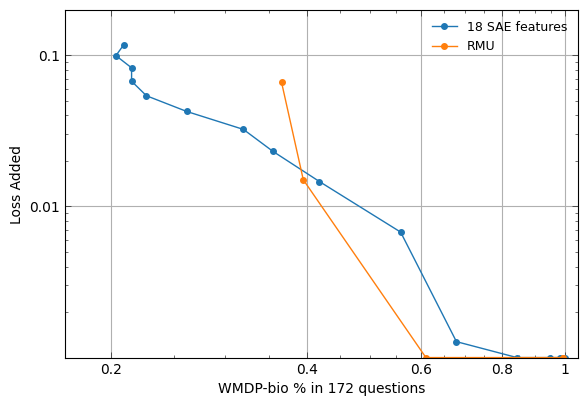

In [99]:
fig, ax = plt.subplots(figsize=(6, 4))

unlearned_frac = [x['modified_metrics']['mean_correct'] for x in metrics_intervention_results2]
loss_added = np.array([x for x in loss_intervention_results2])
loss_added = np.maximum(loss_added, 0.001)

# ax.plot(np.log10(unlearned_frac), np.log10(loss_added))

ax.plot(np.log10(unlearned_frac), np.log10(loss_added), '-o', markersize=4, label="18 SAE features")


rmu_loss_added = [-0.005, -0.005, -0.001, 0.015, 0.0661]
rmu_loss_added = np.maximum(rmu_loss_added, 0.001)
rmu_scores = np.array([0.994, 0.994, 0.6105, 0.3953, 0.366])

ax.plot(np.log10(rmu_scores), np.log10(rmu_loss_added), '-o', markersize=4, label="RMU")


ax.set_xlabel("WMDP-bio % in 172 questions")
ax.set_ylabel("Loss Added")



major_loss_ticks = [0.01, 0.1]
minor_loss_ticks = np.concatenate((np.arange(0.001, 0.01, 0.001),
                                np.arange(0.01, 0.1, 0.01),
                                np.arange(0.1, 1, 0.1)))


ax.set_yticks(np.log10(major_loss_ticks))
ax.set_yticklabels(major_loss_ticks)
ax.set_yticks(np.log10(minor_loss_ticks), minor=True)

major_prob_ticks = [0.2, 0.4, 0.6, 0.8, 1]
minor_prob_ticks = np.arange(0.1, 1, 0.05)

ax.set_xticks(np.log10(major_prob_ticks))
ax.set_xticklabels(major_prob_ticks)
ax.set_xticks(np.log10(minor_prob_ticks), minor=True)

ax.set_xlim(np.log10(0.17), 0.02)
ax.set_ylim(np.log10(0.001), np.log10(0.2))

ax.grid()

# ax.set_xlim(-1, 0)
# ax.set_ylim(0, 0.1)

# ax.invert_xaxis()

ax.legend()

fig.subplots_adjust(right=0.98, top=0.98)
fig_subdir = "pareto_frontiers"
Path(figdir + '/' + fig_subdir).mkdir(parents=True, exist_ok=True)
plt.savefig(figdir + '/' + fig_subdir + '/loss_added_vs_score_v1.png', dpi=600)

# plt.close(fig)
plt.show()



In [68]:
import matplotlib.pyplot as plt



In [49]:
# loss_intervention_results2 = []
metrics_intervention_results2 = []

filtered_good_features = [12663, 4342, 5749, 10355, 1523, 15858, 12273, 14315, 4451, 1611, 10051, 16186, 7983, 6958, 1307, 11019, 6531, 12289]
# filtered_good_features = [12663, 4342, 5749, 10355, 1523, 15858, 12273, 14315, 4451, 1611, 10051, 16186, 7983, 6958, 1307, 11019, 6531, 12289]

multiplier = 20.0

all_permutations = list(itertools.permutations([0, 1, 2, 3]))


for feature in filtered_good_features:
    ul_tool2.base_activation_store.iterable_dataset = iter(ul_tool2.base_activation_store.dataset)
    ablate_params = {
        'features_to_ablate': [feature],
        'multiplier': 10,
        'intervention_method': 'scale_feature_activation',
        'permutations': None,
        'permutations': None,
    }
    
    # metrics = ul_tool2.calculate_metrics(**ablate_params)
    # metrics_intervention_results2.append(metrics)
    print(feature)
    loss_added = ul_tool2.compute_loss_added(n_batch=20, **ablate_params)
    loss_intervention_results2.append(loss_added)


12663


100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


4342


100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


5749


100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


10355


100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


1523


100%|██████████| 20/20 [00:26<00:00,  1.35s/it]


15858


100%|██████████| 20/20 [00:26<00:00,  1.35s/it]


12273


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


14315


100%|██████████| 20/20 [00:27<00:00,  1.35s/it]


4451


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


1611


100%|██████████| 20/20 [00:27<00:00,  1.35s/it]


10051


100%|██████████| 20/20 [00:27<00:00,  1.35s/it]


16186


100%|██████████| 20/20 [00:27<00:00,  1.35s/it]


7983


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


6958


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


1307


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


11019


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


6531


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


12289


100%|██████████| 20/20 [00:27<00:00,  1.35s/it]


In [50]:
[x['modified_metrics']['mean_correct'] for x in metrics_intervention_results2]

[]

In [54]:
losses = np.array([x for x in loss_intervention_results2[-18:]])

[-0.005739045143127441,
 -5.055665969848633e-05,
 0.002261507511138916,
 -0.0028084516525268555,
 0.0018524765968322755,
 -1.9073486328125e-07,
 -3.2341480255126954e-05,
 -0.00047284364700317383,
 0.008104395866394044,
 0.0017570137977600097,
 -0.0001727461814880371,
 -0.00038210153579711916,
 -0.00025604963302612306,
 1.666545867919922e-05,
 0.002155411243438721,
 0.006975841522216797,
 -0.00047327280044555663,
 0.003248286247253418]

In [53]:
# loss_intervention_results2 = []
# metrics_intervention_results2 = []
filtered_good_features = [12663, 4342, 5749, 10355, 1523, 15858, 12273, 14315, 4451, 1611, 10051, 16186, 7983, 6958, 1307, 11019, 6531, 12289]

# filtered_good_features = [12663, 4342, 5749, 10355, 1523, 15858, 12273, 14315, 4451, 1611, 10051, 16186, 7983, 6958, 1307, 11019, 6531, 12289]

multiplier = 20.0

all_permutations = list(itertools.permutations([0, 1, 2, 3]))

ul_tool2.base_activation_store.iterable_dataset = iter(ul_tool2.base_activation_store.dataset)
ablate_params = {
    'features_to_ablate': filtered_good_features,
    'multiplier': 10,
    'intervention_method': 'scale_feature_activation',
    'permutations': all_permutations,
}

metrics = ul_tool2.calculate_metrics(**ablate_params)
# metrics_intervention_results2.append(metrics)
print(feature)
loss_added = ul_tool2.compute_loss_added(n_batch=20, **ablate_params)
# loss_intervention_results2.append(loss_added)


18